# Chapter 13: Analyzing sound waves with Fourier Series

The Lecture Codes are modified from the reference below.

Code Reference 1: Al Sweigart, Making Games with Python & Pygame. Createspace Independent Pub, 2012. https://inventwithpython.com/pygame/
Code Reference 2: Penny de Byl, Mathematics for Game Programming and Computer Graphics. Packt Programming, 2022. https://github.com/PacktPublishing/Mathematics-for-Game-Programming-and-Computer-Graphics/ 
Code Reference 3: Paul Orland, Math for Programmers - 3D graphics, machine learning, and simulations with Python. Manning, 2020.https://github.com/orlandpm/Math-for-Programmers

Helper functions

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_function(f,xmin,xmax,**kwargs):
    ts = np.linspace(xmin,xmax,1000)
    plt.plot(ts,[f(t) for t in ts],**kwargs)
    
def plot_sequence(points,max=100,line=False,**kwargs):
    if line:
        plt.plot(range(0,max),points[0:max],**kwargs)
    else:
        plt.scatter(range(0,max),points[0:max],**kwargs)

## 13.1 Playing sound waves in Python

### 13.1.1 Producing our first sound

In [3]:
import pygame, pygame.sndarray
pygame.mixer.init(frequency=44100, size=-16, channels=2)

pygame 2.5.1 (SDL 2.28.2, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


44100


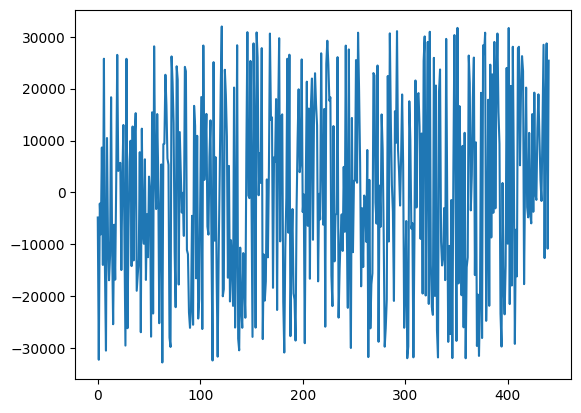

In [4]:
import numpy as np
arr = np.random.randint(-32768, 32767, size=44100)
print(len(arr))


plot_sequence(arr,line=True,max=441)

**CAUTION: May play a loud sound!!!**

In [9]:
buffer = np.repeat(arr.reshape(len(arr), 1), 2, axis = 1)
print(buffer)
sound = pygame.sndarray.make_sound(buffer)
sound.play()

[[ -4837  -4837]
 [-32240 -32240]
 [ -2147  -2147]
 ...
 [ -6559  -6559]
 [   897    897]
 [ 11569  11569]]


In [10]:
arr = np.random.randint(-10000, 10000, size=44100)
buffer = np.repeat(arr.reshape(len(arr), 1), 2, axis = 1)

sound = pygame.sndarray.make_sound(buffer)
sound.play()

### 13.1.2 Playing a musical note

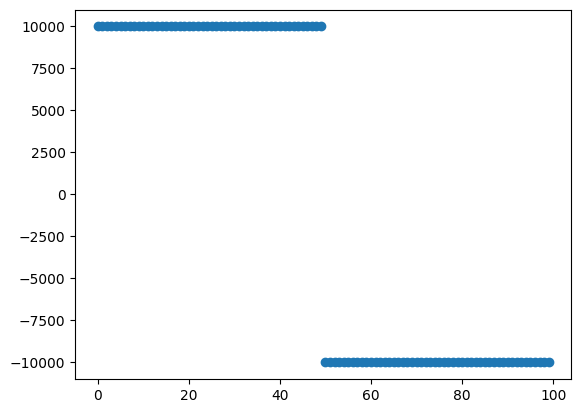

In [11]:
form = np.repeat([10000,-10000],50) #<1>
plot_sequence(form)

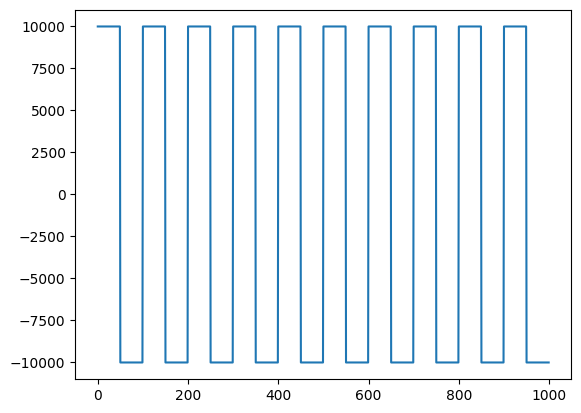

In [12]:
arr = np.tile(form,441)
plot_sequence(arr,line=True,max=1000)

buffer = np.repeat(arr.reshape(len(arr), 1), 2, axis = 1)

sound = pygame.sndarray.make_sound(buffer)
sound.play()

### 13.1.3 Exercises

**Exercise:** Our musical note “A” was a pattern that repeated 441 times in a second.  Create a similar pattern that repeats 350 times in one second, which will produce the musical note “F”.

**Solution:**

In [13]:
form = np.repeat([10000,-10000], 63)
arr = np.tile(form, 350) # 44100 / 350 / 2 한게 위의 63임.

buffer = np.repeat(arr.reshape(len(arr), 1), 2, axis = 1)

sound = pygame.sndarray.make_sound(buffer)
sound.play()

## 13.2 Turning a sinusoidal wave into a sound

### 13.2.1 Making audio from sinusoidal functions

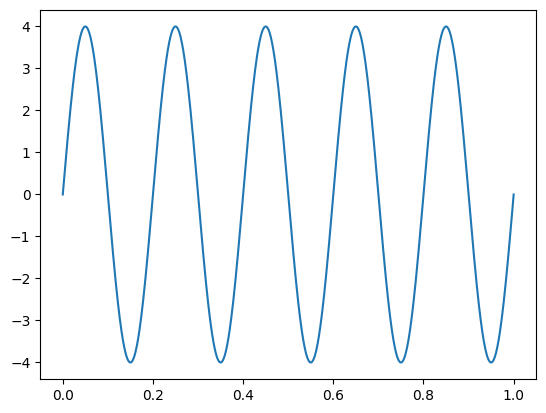

In [17]:
from math import sin,cos,pi

def make_sinusoid(frequency,amplitude):
    def f(t): #<1>
        return amplitude * sin(2*pi*frequency*t) #<2>
    return f

plot_function(make_sinusoid(5,4),0,1)

### 13.2.2 Sampling and playing the sound wave

In [14]:
#0-1초 내에서 샘플링 간격을 조정
np.arange(0,1,0.1)
np.arange(0,1,1/44100) 

array([0.00000000e+00, 2.26757370e-05, 4.53514739e-05, ...,
       9.99931973e-01, 9.99954649e-01, 9.99977324e-01])

In [15]:
def sample(f,start,end,count): #<1>
    mapf = np.vectorize(f) #<2>
    ts = np.arange(start,end,(end-start)/count) #<3>
    values = mapf(ts) #<4>
    return values.astype(np.int16) #<5>

In [19]:
sinusoid = make_sinusoid(441,8000)
arr = sample(sinusoid, 0, 1, 44100)

buffer = np.repeat(arr.reshape(len(arr), 1), 2, axis = 1)

sound = pygame.sndarray.make_sound(buffer)
sound.play()

### 13.2.3 Exercises

**Exercise:** Find the value of $k$ such that $\cos(kt)$ has a frequency of 5.  Plot the resulting function $\cos(kt)$ from zero to one and show that it repeats itself 5 times.

**Solution:**

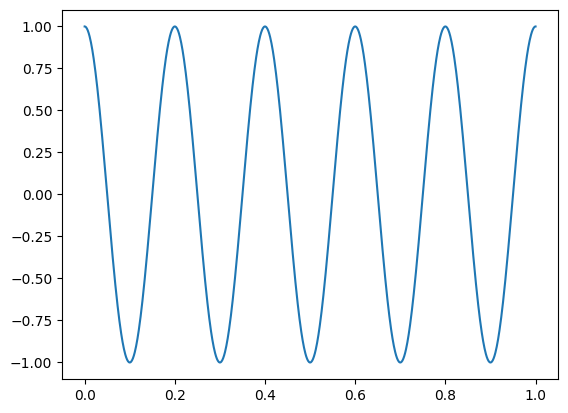

In [20]:
plot_function(lambda t: cos(2*pi*5*t),0,1)

## 13.3 Combining sound waves to make new ones

### 13.3.1 Adding sampled sound waves to build a chord

In [21]:
np.array([1,2,3]) + np.array([4,5,6])

array([5, 7, 9])

In [35]:
sample1 = sample(make_sinusoid(441,8000),0,1,44100)
# sample2 = sample(make_sinusoid(551,8000),0,1,44100) # 화음이 들림
sample2 = sample(make_sinusoid(445,8000),0,1,44100) # beating
buffer1 = np.repeat(sample1.reshape(len(sample1), 1), 2, axis = 1)
buffer2 = np.repeat(sample2.reshape(len(sample2), 1), 2, axis = 1)

sound1 = pygame.sndarray.make_sound(buffer1)
sound2 = pygame.sndarray.make_sound(buffer2)

sound1.play()
sound2.play()

In [36]:
chord = pygame.sndarray.make_sound(buffer1 + buffer2) # 화음
chord.play()

In [33]:
sample1 = sample(make_sinusoid(441,80),0,1,44100)
sample2 = sample(make_sinusoid(441,8000),0,1,44100)

buffer = np.concatenate((sample1.reshape(len(sample1), 1), sample2.reshape(len(sample2), 1)), axis=1)

sound3 = pygame.sndarray.make_sound(buffer) # the most simple panning
sound3.play()

### 13.3.2 Picturing the sum of two sound waves

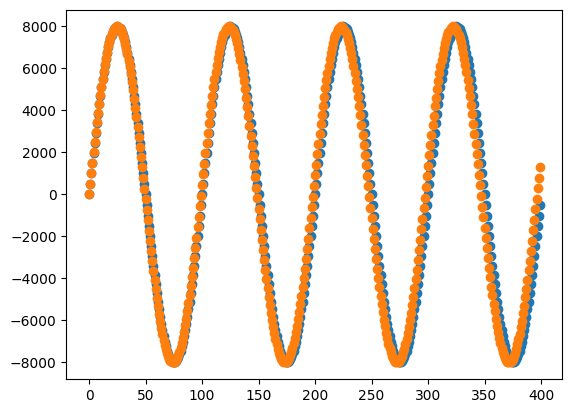

In [37]:
plot_sequence(sample1,max=400)
plot_sequence(sample2,max=400)

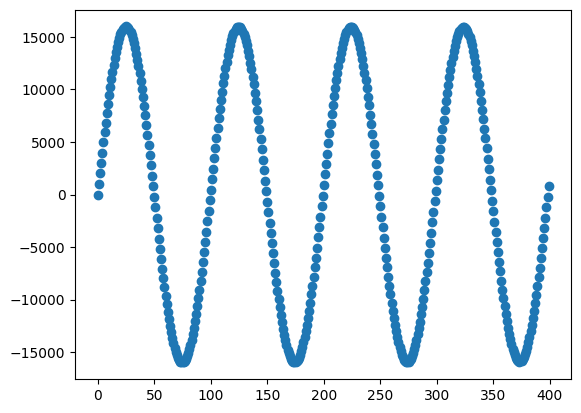

In [38]:
plot_sequence(sample1+sample2,max=400)

### 13.3.3 Building a linear combination of sinusoids

In [39]:
def const(n):
    return 1

def fourier_series(a0,a,b):
    def result(t):
        cos_terms = [an*cos(2*pi*(n+1)*t) for (n,an) in enumerate(a)] #<1>
        sin_terms = [bn*sin(2*pi*(n+1)*t) for (n,bn) in enumerate(b)] #<2>
        return a0*const(t) + sum(cos_terms) + sum(sin_terms) #<3>
    return result

In [40]:
f = fourier_series(0,[0,0,0,0,0],[0,0,0,1,1])

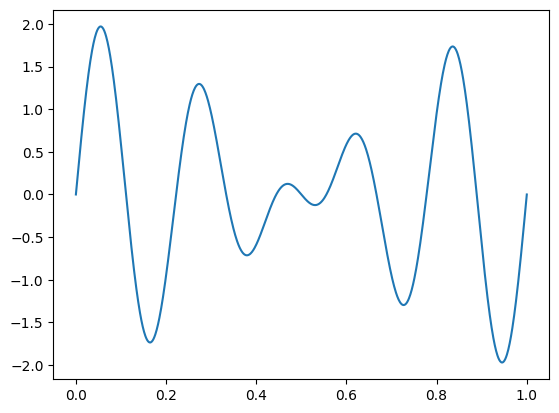

In [41]:
plot_function(f,0,1)

### 13.3.4 Building a familiar function with sinusoids

In [42]:
f1 = fourier_series(0,[],[4/pi])

In [43]:
f3 = fourier_series(0,[],[4/pi,0,4/(3*pi)])

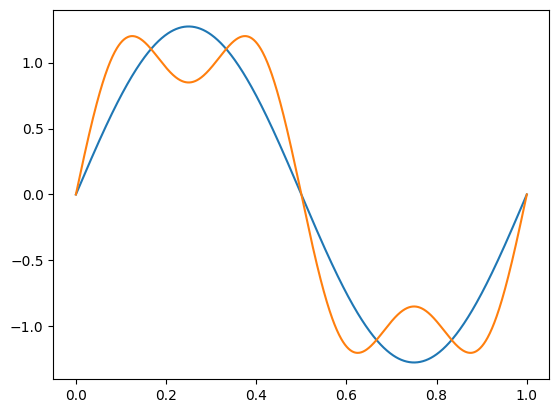

In [44]:
plot_function(f1,0,1)
plot_function(f3,0,1)

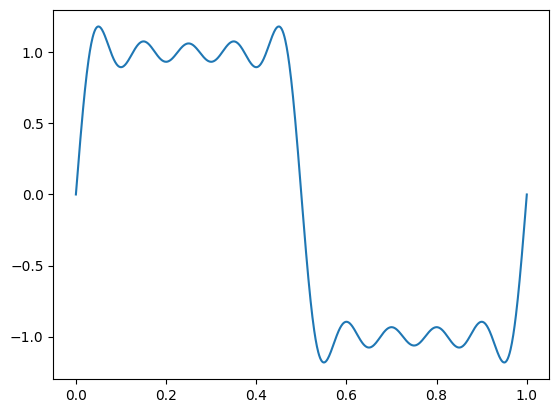

In [45]:
b = [4/(n * pi) if n%2 != 0 else 0 for n in range(1,10)] #<1>
f = fourier_series(0,[],b)
plot_function(f,0,1)

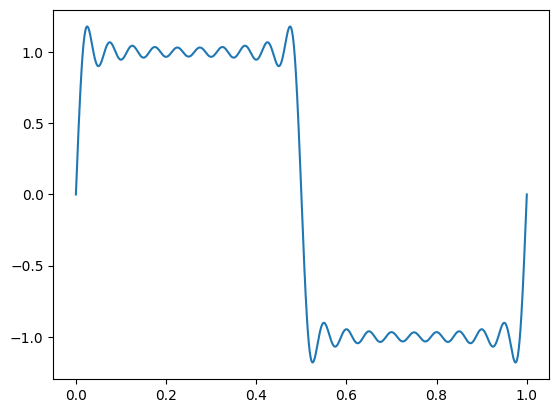

In [46]:
b = [4/(n * pi) if n%2 != 0 else 0 for n in range(1,20)]
f = fourier_series(0,[],b)
plot_function(f,0,1)

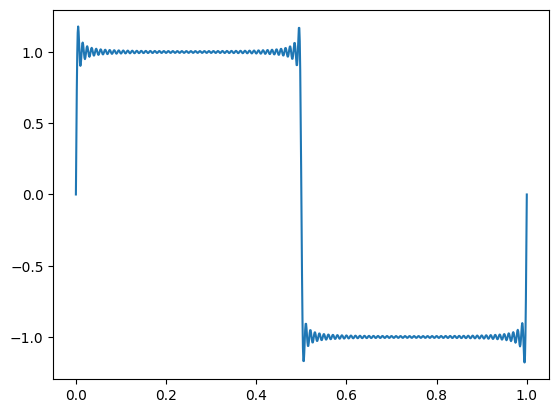

In [47]:
b = [4/(n * pi) if n%2 != 0 else 0 for n in range(1,100)]
f = fourier_series(0,[],b)
plot_function(f,0,1)

### 13.3.5 Exercises

**Mini-project:** Create a manipulated version of the square wave Fourier series so that is frequency is 441 Hz, sample it, and confirm that it doesn’t just look like the square wave -- it sounds like the square wave as well.

**Solution:** Here's a quick idea of how to do this with the function `f` you just built.

In [29]:
arr = sample(lambda t: 10000* f(441*t), 0, 1, 44100)

buffer = np.repeat(arr.reshape(len(arr), 1), 2, axis = 1)

sound = pygame.sndarray.make_sound(buffer)
sound.play()

## 13.4 Decomposing a sound wave into its Fourier Series

### 13.4.1 Finding vector components with an inner product

### 13.4.2 Defining an inner product for periodic functions

In [30]:
def inner_product(f,g,N=1000):
    dt = 1/N #<1>
    return 2*sum([f(t)*g(t)*dt for t in np.arange(0,1,dt)]) #<2>

In [31]:
def s(n): #<1>
    def f(t):
        return sin(2*pi*n*t)
    return f

def c(n): #<2>
    def f(t):
        return cos(2*pi*n*t)
    return f

In [32]:
inner_product(s(1),c(1))

4.2197487366314734e-17

In [33]:
inner_product(s(1),s(2))

-1.4176155163484784e-18

In [34]:
inner_product(c(3),s(10))

-1.7092447249233977e-16

In [35]:
inner_product(s(1),s(1))

1.0000000000000002

In [36]:
inner_product(c(1),c(1))

0.9999999999999999

In [37]:
inner_product(c(3),c(3))

1.0

In [38]:
from math import sqrt

def const(n):
    return 1 /sqrt(2)

In [39]:
inner_product(const,s(1))

-2.2580204307905138e-17

In [40]:
inner_product(const,c(1))

-3.404394821604484e-17

In [41]:
inner_product(const,const)

1.0000000000000007

### 13.4.3 Writing a function to find Fourier coefficients

**note** we have a new `const` function so `fourier_series` will behave differently

In [42]:
def fourier_series(a0,a,b):
    def result(t):
        cos_terms = [an*cos(2*pi*(n+1)*t) for (n,an) in enumerate(a)] #<1>
        sin_terms = [bn*sin(2*pi*(n+1)*t) for (n,bn) in enumerate(b)] #<2>
        return a0*const(t) + sum(cos_terms) + sum(sin_terms) #<3>
    return result

In [43]:
def fourier_coefficients(f,N):
    a0 = inner_product(f,const) #<1>
    an = [inner_product(f,c(n)) for n in range(1,N+1)] #<2>
    bn = [inner_product(f,s(n)) for n in range(1,N+1)] #<3>
    return a0, an, bn

In [44]:
f = fourier_series(0,[2,3,4],[5,6,7])

In [45]:
fourier_coefficients(f,3)

(-3.812922200197022e-15,
 [1.9999999999999887, 2.999999999999999, 4.0],
 [5.000000000000002, 6.000000000000001, 7.0000000000000036])

### 13.4.4 Finding the Fourier coefficients for the square wave

In [46]:
def square(t):
    return 1 if (t%1) < 0.5 else -1

In [47]:
a0, a, b = fourier_coefficients(square,10)

In [48]:
b[0], 4/pi

(1.273235355942202, 1.2732395447351628)

In [49]:
b[2], 4/(3*pi)

(0.4244006151333577, 0.4244131815783876)

In [50]:
b[4], 4/(5*pi)

(0.2546269646514865, 0.25464790894703254)

### 4.5 Fourier coefficients for other waveforms

In [51]:
def sawtooth(t):
    return t%1

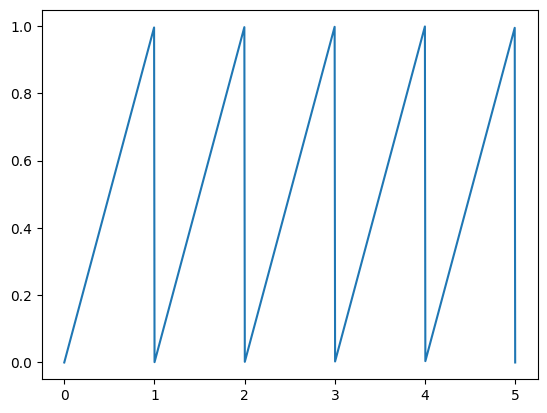

In [52]:
plot_function(sawtooth,0,5)

In [53]:
approx = fourier_series(*fourier_coefficients(sawtooth,10))

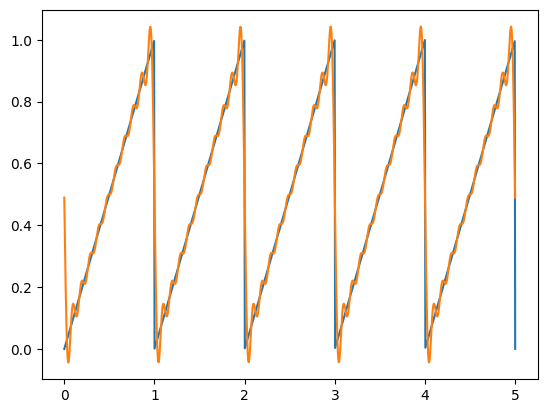

In [54]:
plot_function(sawtooth,0,5)
plot_function(approx,0,5)

In [55]:
def speedbumps(t):
    if abs(t%1 - 0.5) > 0.25:
        return 0
    else:
        return sqrt(0.25*0.25 - (t%1 - 0.5)**2)

In [56]:
approx = fourier_series(*fourier_coefficients(speedbumps,10))

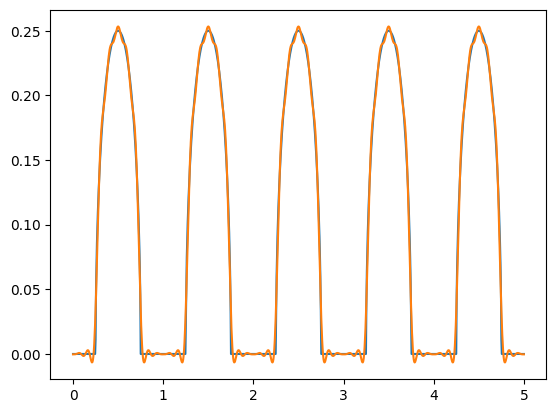

In [57]:
plot_function(speedbumps,0,5)
plot_function(approx,0,5)

### 13.4.6 Exercises

**Mini project:** Play a sawtooth wave at 441 Hz and compare it with the square and sinusoidal waves you played at that frequency.

**Solution:**

In [58]:
def modified_sawtooth(t):
    return 8000 * sawtooth(441*t)
arr = sample(modified_sawtooth,0,1,44100)

buffer = np.repeat(arr.reshape(len(arr), 1), 2, axis = 1)

sound = pygame.sndarray.make_sound(buffer)
sound.play()